# 0. NOTES


FULL CODE EXAMPLE FOR A SIMPLE CHATBOT USING BOTH:
1) An Artificial Neural Network (ANN)
2) A Transformer-Based Model

This script demonstrates:
  - Environment setup (imports)
  - Data loading and preprocessing
   - ANN model training and inference
   - Transformer model training and inference
   - Performance comparison

# NOTE:
   - The code below is a unified example; in practice, you might split it into multiple files (e.g., data_preprocessing.py, models.py, train.py).
   - Adjust file paths, hyperparameters, and dataset loading as necessary.
   - Ensure the product_reviews.csv file has columns named "review" and "label".
   - Installing dependencies (outside of Python):
      pip install torch torchvision torchaudio
      pip install numpy pandas scikit-learn

Please note that for large or complex datasets, a more efficient approach (especially for the Transformer part) might be needed. 

# 1. ENVIRONMENT SETUP & IMPORTS

In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report


# 2. DATA LOADING & PREPROCESSING

In [4]:
# Adjust the path to your local product_reviews.csv file as needed.
CSV_PATH = r"amazon_cells_labelled.txt"


def basic_preprocessing(text):
    """
    Example text preprocessing step:
    - Lowercase the text
    - Strip leading/trailing spaces
    - Optionally remove punctuation, etc.
    """
    text = text.lower().strip()
    return text

def load_and_preprocess_data(csv_path):
    """
    Loads data from a CSV file containing 'review' and 'label' columns.
    Applies a basic preprocessing function to the text.
    Splits into train, validation, and test sets.
    Returns dataframes (train, val, test).
    """
    data = pd.read_csv(csv_path, sep='\t', header=None, names=['review', 'label'])
    data['review'] = data['review'].apply(basic_preprocessing)
    
    # Train/test split (80/20), then split the training set again for validation
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
    
    return train_data, val_data, test_data

train_data, val_data, test_data = load_and_preprocess_data(CSV_PATH)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")


Training samples: 640
Validation samples: 160
Test samples: 200


In [3]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        }, ignore_index=True)
    return data

# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index                                          # add new column index
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas(data, columns)                             # pre-process
    training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )

    # vectorize data using TFIDF and transform for PyTorch for scalability
    word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
    training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
    training_data = training_data.todense()                             # convert to dense matrix for Pytorch
    vocab_size = len(word_vectorizer.vocabulary_)
    validation_data = word_vectorizer.transform(validation_data)
    validation_data = validation_data.todense()
    train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
    train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
    validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
    validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        }, ignore_index=True)
    return data

# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index                                          # add new column index
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas(data, columns)                             # pre-process
    training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )

    # vectorize data using TFIDF and transform for PyTorch for scalability
    word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
    training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
    training_data = training_data.todense()                             # convert to dense matrix for Pytorch
    vocab_size = len(word_vectorizer.vocabulary_)
    validation_data = word_vectorizer.transform(validation_data)
    validation_data = validation_data.todense()
    train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
    train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
    validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
    validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\addod/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\addod\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


# 3. FEATURE EXTRACTION

In [5]:
# We use a simple Bag-of-Words vectorizer for demonstration.
vectorizer = CountVectorizer()

# Fit vectorizer on training reviews
X_train = vectorizer.fit_transform(train_data['review']).toarray()
y_train = train_data['label'].values

# Transform validation and test reviews
X_val = vectorizer.transform(val_data['review']).toarray()
y_val = val_data['label'].values

X_test = vectorizer.transform(test_data['review']).toarray()
y_test = test_data['label'].values 


# 4. TASK 1.1: ANN MODEL DEFINITION & TRAINING

Epoch [1/5], Train Loss: 0.6885, Val Loss: 0.6783, Train Acc: 0.5609, Val Acc: 0.6813
Epoch [2/5], Train Loss: 0.6363, Val Loss: 0.6384, Train Acc: 0.8797, Val Acc: 0.7750
Epoch [3/5], Train Loss: 0.5360, Val Loss: 0.5727, Train Acc: 0.9219, Val Acc: 0.7750
Epoch [4/5], Train Loss: 0.4013, Val Loss: 0.5132, Train Acc: 0.9437, Val Acc: 0.7562
Epoch [5/5], Train Loss: 0.2828, Val Loss: 0.4759, Train Acc: 0.9672, Val Acc: 0.7812


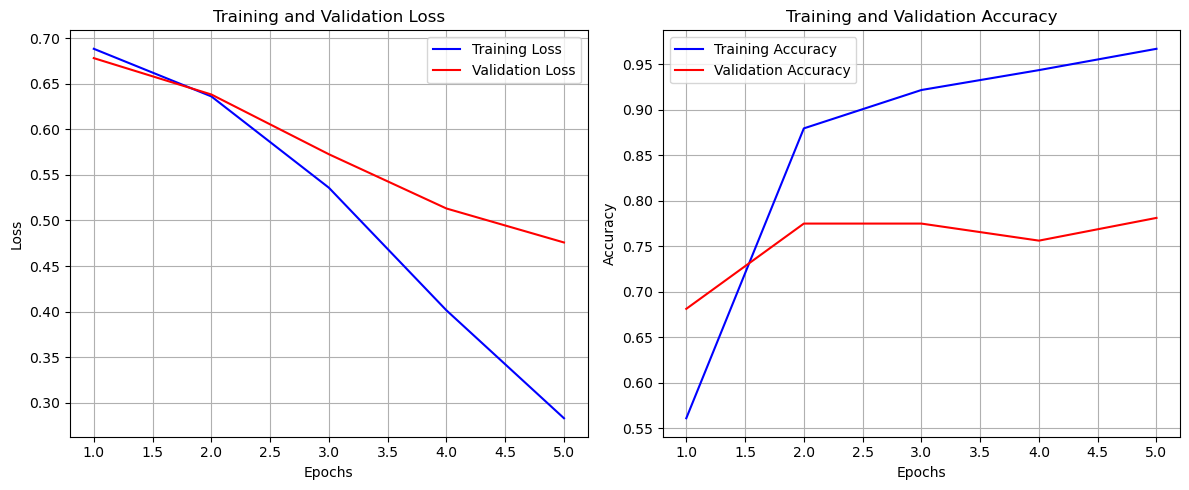

Type something for the ANN-based chatbot:  hello


It seems negative.


In [ ]:
class SimpleANN(nn.Module):
    """
    A simple feed-forward ANN for binary classification (sentiment analysis).
    """
    def __init__(self, input_dim, hidden_dim=128, output_dim=1):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the ANN
input_dim = X_train.shape[1]  # Number of features from BOW
model_ann = SimpleANN(input_dim, hidden_dim=128, output_dim=1)

criterion_ann = nn.BCELoss()  # Binary cross-entropy loss
optimizer_ann = optim.Adam(model_ann.parameters(), lr=0.001)

X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(y_train).view(-1, 1)
X_val_torch = torch.FloatTensor(X_val)
y_val_torch = torch.FloatTensor(y_val).view(-1, 1)

def train_ann(model, criterion, optimizer, epochs=5, batch_size=32):
    """
    Trains the ANN model for a given number of epochs and batch size.
    Prints training and validation loss at each epoch.
    """

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for i in range(0, len(X_train_torch), batch_size):
            x_batch = X_train_torch[i:i+batch_size]
            y_batch = y_train_torch[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        with torch.no_grad():
            val_outputs = model(X_val_torch)
            val_loss = criterion(val_outputs, y_val_torch)

            # Calculate validation accuracy
            val_predicted = (val_outputs > 0.5).float()
            correct_val = (val_predicted == y_val_torch).sum().item()
            val_acc = correct_val / len(X_val_torch)
        
        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(val_acc)


        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {running_loss/len(X_train_torch):.4f}, "
              f"Val Loss: {val_loss.item():.4f}"
              f"Train Acc: {epoch_train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}")
        
    return train_losses, val_losses, train_accuracies, val_accuracies


def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    """
    Plots the training and validation loss and accuracy curves.
    """
    epochs_range = range(1, epochs + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = train_ann(
    model_ann, criterion_ann, optimizer_ann, epochs=num_epochs, batch_size=32
)

# Plot the metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs)


def chatbot_response_ann(model, user_input):
    """
    Takes user input, vectorizes it using the same vectorizer,
    feeds it into the ANN model, and returns a sentiment response.
    """
    user_vec = vectorizer.transform([user_input]).toarray()
    user_tensor = torch.FloatTensor(user_vec)
    
    model.eval()
    with torch.no_grad():
        output = model(user_tensor)
    
    sentiment_positive = (output.item() > 0.5)
    if sentiment_positive:
        return "It sounds positive!"
    else:
        return "It seems negative."

user_input_example = input("Type something for the ANN-based chatbot: ")
print(chatbot_response_ann(model_ann, user_input_example))


### TESTING MULTIPLE SENTENCES ON THE CHATBOT:

In [ ]:
num_runs = 5
for i in range(num_runs): 
    user_input_example = input("Type something for the ANN-based chatbot: ")
    print(f"You said: {user_input_example}")  # Print user input before response
    print(chatbot_response_ann(model_ann, user_input_example))  # Print chatbot response

You said: Diva is not good
It seems negative.
You said: You are very kind to me
It seems negative.
You said: Everything is fucked
It sounds positive!
You said: I am in a huge debt
It seems negative.
You said: Ok
It seems negative.


# 5. TASK 1.2: TRANSFORMER MODEL DEFINITION & TRAINING

Training samples: 20
Validation samples: 5
Test samples: 7


/home/walle/anaconda3/envs/nnlm/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Train Loss: 1.5461, Val Loss: 0.6628Train Acc: 0.5469, Val Acc: 0.5375
Epoch [2/5], Train Loss: 0.4417, Val Loss: 0.6332Train Acc: 0.8250, Val Acc: 0.7500
Epoch [3/5], Train Loss: 0.2036, Val Loss: 0.8246Train Acc: 0.9391, Val Acc: 0.7562
Epoch [4/5], Train Loss: 0.0926, Val Loss: 1.1354Train Acc: 0.9781, Val Acc: 0.7375
Epoch [5/5], Train Loss: 0.1093, Val Loss: 0.8471Train Acc: 0.9688, Val Acc: 0.7750


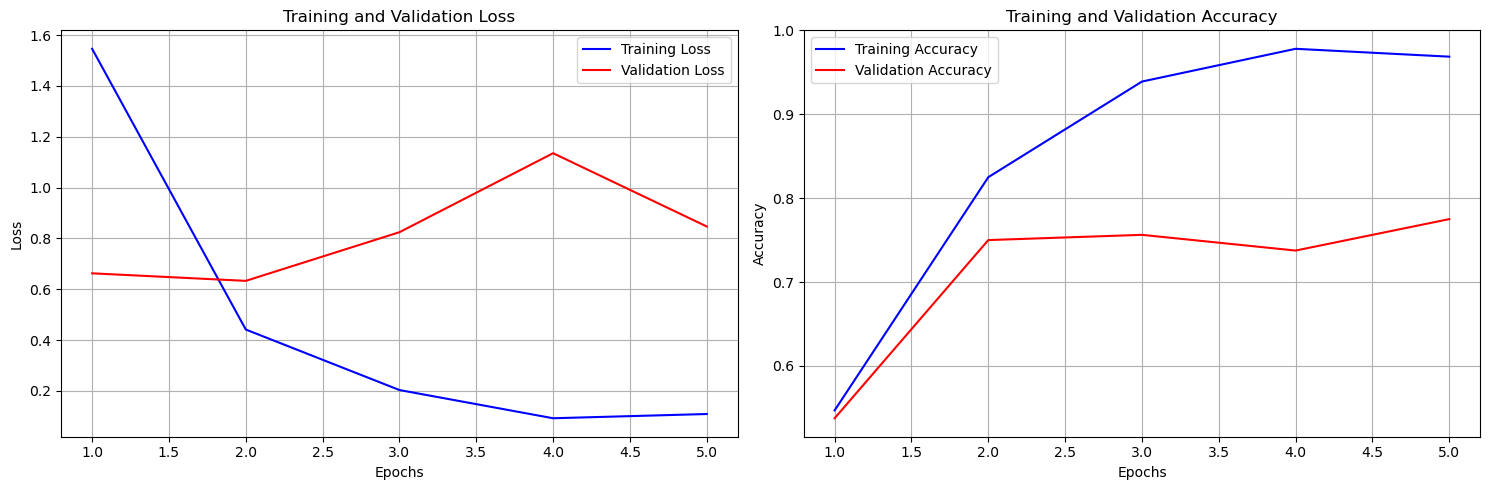

In [8]:
import math
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class ReviewsDataset(Dataset):
    """
    Torch Dataset that takes in lists (or Series) of texts and labels
    along with the vectorizer to transform texts.
    """
    def __init__(self, texts, labels, vectorizer):
        # Reset index to ensure consistent indexing
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)  # Ensure labels have matching indices
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Debug: print index being fetched (remove in production)
        # print(f"Fetching index: {idx}")
        text = self.texts[idx]
        label = self.labels[idx]
        # Transform text to a dense vector
        text_vector = self.vectorizer.transform([text]).toarray()
        return torch.FloatTensor(text_vector), torch.FloatTensor([label])
    
# Reset indices in your data
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_dataset = ReviewsDataset(train_data['review'], train_data['label'], vectorizer)
val_dataset = ReviewsDataset(val_data['review'], val_data['label'], vectorizer)
test_dataset = ReviewsDataset(test_data['review'], test_data['label'], vectorizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(f"Training samples: {len(train_loader)}")
print(f"Validation samples: {len(val_loader)}")
print(f"Test samples: {len(test_loader)}")



class TransformerClassifier(nn.Module):
    """
    A basic Transformer-based model for binary classification.
    For simplicity, we:
      - Use a TransformerEncoder to process an entire BOW vector as if it were a single token.
      - Then pass the output to a linear layer -> sigmoid for classification.
    """
    def __init__(self, input_dim, nhead=4, num_layers=2, hidden_dim=128):
        super(TransformerClassifier, self).__init__()

        # Adjust input_dim to be divisible by nhead
        if input_dim % nhead != 0:
            d_model = math.ceil(input_dim / nhead) * nhead  # Round up to nearest multiple
            print(f"⚠️ Warning: Adjusting input_dim from {input_dim} to {d_model} for compatibility with nhead={nhead}.")
        else:
            d_model = input_dim

        self.d_model = d_model  # Expected embedding dimension
        
        # Use the adjusted dimension for the Transformer
        self.encoder_layer = TransformerEncoderLayer(d_model=self.d_model, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        self.linear = nn.Linear(self.d_model, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, src):
        # src shape: (batch_size, 1, original_dim)
        # Check if padding is needed
        original_dim = src.size(-1)
        if original_dim < self.d_model:
            pad_size = self.d_model - original_dim
            # Create padding tensor with zeros
            pad_tensor = torch.zeros(src.size(0), 1, pad_size, device=src.device, dtype=src.dtype)
            src = torch.cat((src, pad_tensor), dim=-1)
        elif original_dim > self.d_model:
            # Optionally, you could truncate if the input is too large.
            src = src[:, :, :self.d_model]
        
        # Transformer expects input of shape (sequence_length, batch_size, d_model).
        # Here we treat the entire vector as a single token, so sequence_length=1.
        src = src.transpose(0, 1)  # Now shape: (1, batch_size, d_model)
        
        encoded = self.transformer_encoder(src)
        encoded_output = encoded[0]  # Take the output corresponding to the single token (shape: batch_size, d_model)
        
        logits = self.linear(encoded_output)
        probs = self.sigmoid(logits)
        return probs

# Fix input_dim before passing it into the model:
# Use X_train.shape[1] as the original dimension from TF-IDF. 
original_input_dim = X_train.shape[1]
adjusted_input_dim = math.ceil(original_input_dim / 4) * 4  # This is our target dimension.
model_transformer = TransformerClassifier(input_dim=adjusted_input_dim, nhead=4, num_layers=2, hidden_dim=128)

criterion_transformer = nn.BCELoss()
optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=0.001)

def train_transformer(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    """
    Trains the Transformer model using the provided data loaders.
    Prints training and validation loss per epoch.
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_true = []
        
        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Store predictions and true labels for accuracy calculation
            preds = (outputs > 0.5).float()
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []

        with torch.no_grad():
            for val_texts, val_labels in val_loader:
                val_outputs = model(val_texts)
                val_loss += criterion(val_outputs, val_labels).item()

                # Store predictions and true labels for accuracy calculation
                preds = (val_outputs > 0.5).float()
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(val_labels.cpu().numpy())
        
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = accuracy_score(np.array(train_true).flatten(), np.array(train_preds).flatten())
        val_accuracy = accuracy_score(np.array(val_true).flatten(), np.array(val_preds).flatten())

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}"
              f"Train Acc: {train_accuracy:.4f}, "
              f"Val Acc: {val_accuracy:.4f}")
        
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and collect metrics
train_losses, val_losses, train_accuracies, val_accuracies = train_transformer(
    model_transformer, criterion_transformer, optimizer_transformer, train_loader, val_loader, epochs=5
)

# Plot the metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout and display plot
plt.tight_layout()
plt.show()


def chatbot_response_transformer(model, user_input):
    """
    Takes user input, vectorizes it using the same BOW vectorizer,
    feeds it into the Transformer model, and returns a sentiment response.
    """
    user_vec = vectorizer.transform([user_input]).toarray()
    user_tensor = torch.FloatTensor(user_vec)
    
    # Check if the model has a d_model attribute (Transformer-specific)
    if hasattr(model, "d_model"):
        if user_tensor.size(-1) < model.d_model:
            pad_size = model.d_model - user_tensor.size(-1)
            pad_tensor = torch.zeros(user_tensor.size(0), user_tensor.size(1), pad_size)
            user_tensor = torch.cat((user_tensor, pad_tensor), dim=-1)
        elif user_tensor.size(-1) > model.d_model:
            user_tensor = user_tensor[:, :, :model.d_model]
    
    model.eval()
    with torch.no_grad():
        output = model(user_tensor)
    
    sentiment_positive = (output.item() > 0.5)
    return "It sounds positive!" if sentiment_positive else "It seems negative."

### TESTING THE TRANSFORMER ON A FEW SENTENCES AS DONE WITH THE ANN PREVIOUSLY:

In [ ]:
num_runs = 5
for i in range(num_runs): 
    user_input_example = input("Type something for the ANN-based chatbot: ")
    print(f"You said: {user_input_example}")  # Print user input before response
    print(chatbot_response_transformer(model_transformer, user_input_example))  # Print chatbot response

You said: You're ok
It sounds positive!
You said: I am not brave at all
It seems negative.
You said: I'm trying my best to not be rude
It seems negative.
You said: I'm not not rude
It seems negative.
You said: You're not not not rude
It seems negative.


# 6. TASK 1.3: MODEL COMPARISON

Confusion matrix for  ANN  model:


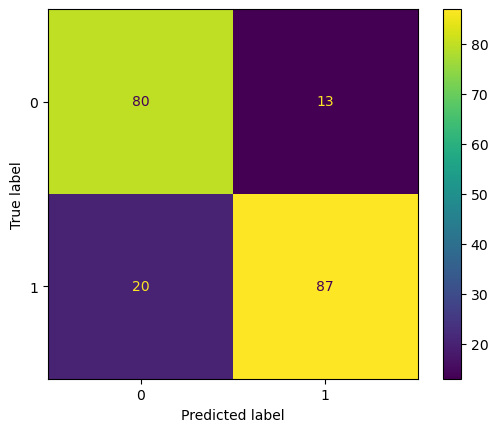

recal =  0.8130841121495327
precision =  0.87
F1_score =  0.8405797101449274 

Confusion matrix for  transformer  model:


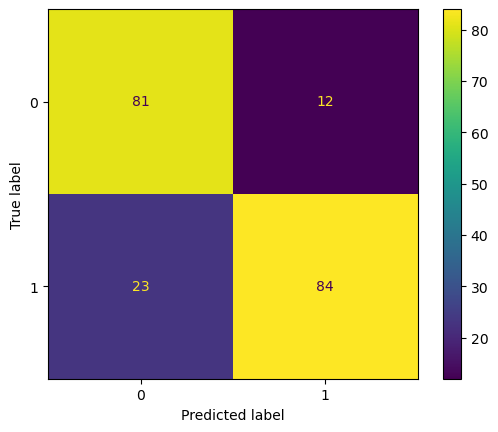

recal =  0.7850467289719626
precision =  0.875
F1_score =  0.8275862068965517 


FINAL TEST ACCURACIES
ANN Test Accuracy: 0.8350
Transformer Test Accuracy: 0.8250


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def evaluate_model(model, X_data, y_data):
    """
    Evaluates the ANN model on a dataset represented by X_data (NumPy array)
    and y_data (NumPy array of labels). Returns accuracy.
    """
    model.eval()
    X_torch = torch.FloatTensor(X_data)
    with torch.no_grad():
        outputs = model(X_torch)
    preds = (outputs.numpy() > 0.5).astype(int)
    accuracy = accuracy_score(y_data, preds)
    
    confusion_matrix_and_values(y_data, preds, "ANN")
    return accuracy

def evaluate_model_transformer(model, data_loader):
    """
    Evaluates the Transformer model using a DataLoader.
    Returns accuracy on that dataset.
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in data_loader:
            outputs = model(texts)
            preds = (outputs.numpy() > 0.5).astype(int).flatten()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy().flatten())
    confusion_matrix_and_values(all_labels, all_preds, "transformer")
    return accuracy_score(all_labels, all_preds)

def confusion_matrix_and_values(labels, predictions, modelname):
    print("Confusion matrix for ", modelname, " model:")
    T_N = 0
    T_P = 0
    F_N = 0
    F_P = 0
    i = 0
    for label in labels:
        if(label-predictions[i] == 0):
            if(label+predictions[i] > 0):
                T_P += 1
            else:
                T_N += 1
        elif(label-predictions[i] == -1):
            F_P += 1
        else:
            F_N += 1
        i += 1
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    precision = T_P/(T_P+F_P)
    recal = T_P/(T_P+F_N)
    print("recal = ", recal)
    print("precision = ", precision)
    print("F1_score = ", 2*precision*recal/(precision+recal), "\n")
    
# ANN test accuracy
ann_test_accuracy = evaluate_model(model_ann, X_test, y_test)

# Transformer test accuracy
transformer_test_accuracy = evaluate_model_transformer(model_transformer, test_loader)

print("\n======================")
print("FINAL TEST ACCURACIES")
print("======================")
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")
print(f"Transformer Test Accuracy: {transformer_test_accuracy:.4f}")
print("======================")    